# Multiple Linear Regression

## Importing the libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Importing the dataset

In [ ]:
dataset = pd.read_csv('ds_salaries.csv')

In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 607 entries, 0 to 606
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          607 non-null    int64 
 1   work_year           607 non-null    int64 
 2   experience_level    607 non-null    object
 3   employment_type     607 non-null    object
 4   job_title           607 non-null    object
 5   salary              607 non-null    int64 
 6   salary_currency     607 non-null    object
 7   salary_in_usd       607 non-null    int64 
 8   employee_residence  607 non-null    object
 9   remote_ratio        607 non-null    int64 
 10  company_location    607 non-null    object
 11  company_size        607 non-null    object
dtypes: int64(5), object(7)
memory usage: 57.0+ KB


In [ ]:
dataset.head()

,Unnamed: 0,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L
1,1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S
2,2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M
3,3,2020,MI,FT,Product Data Analyst,20000,USD,20000,HN,0,HN,S
4,4,2020,SE,FT,Machine Learning Engineer,150000,USD,150000,US,50,US,L


# Dataframe manipulation

In [ ]:
# Subtract the employment year to 2023
dataset['work_year'] = 2023 - dataset['work_year']

In [ ]:
# Drop unnecessary columns
dataset = dataset.drop(columns = ['Unnamed: 0', 'salary', 'salary_currency'])

# Move column 'salary_in_usd' to the end
dataset = dataset[[col for col in dataset.columns if col != 'salary_in_usd'] + ['salary_in_usd']]

In [ ]:
# Group job titles
conditions = [
    dataset['job_title'].str.contains('Scientist|Researcher', case=False),
    dataset['job_title'].str.contains('Engineer|Architect|Developer', case=False),
    dataset['job_title'].str.contains('Analyst|Specialist', case=False),
    dataset['job_title'].str.contains('Manager|Lead', case=False),
    dataset['job_title'].str.contains('Director', case=False),
    dataset['job_title'].str.contains('Consultant', case=False)
]

# Assign corresponding values based on conditions
values = ['Scientist', 'Engineer', 'Analyst', 'Manager', 'Director', 'Consultant']

# Create a new Series with the mapped values
group_job_title = np.select(conditions, values, default='Other')

# Add the new column (named 'group_job_title') to the DataFrame
dataset['group_job_title'] = group_job_title

# Move the column beside job_title
col = dataset.pop('group_job_title')
dataset.insert(4, col.name, col)
dataset = dataset.drop(columns = ['job_title'])

In [ ]:
# Group employee_residence and company_location
# Define the list of countries to check for
countries_to_check = ['US', 'GB', 'IN', 'CA', 'DE', 'FR', 'ES', 'GR']

#Apply the condition and replace values for 'employee_residence' column
employee_residence_condition = dataset['employee_residence'].str.upper().str.contains('|'.join(countries_to_check), case=False)
dataset['employee_residence'] = np.where(employee_residence_condition, dataset['employee_residence'], 'Other')

# Apply the condition and replace values for 'company_location' column
company_location_condition = dataset['company_location'].str.upper().str.contains('|'.join(countries_to_check), case=False)
dataset['company_location'] = np.where(company_location_condition, dataset['company_location'], 'Other')

In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 607 entries, 0 to 606
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           607 non-null    int64 
 1   experience_level    607 non-null    object
 2   employment_type     607 non-null    object
 3   group_job_title     607 non-null    object
 4   employee_residence  607 non-null    object
 5   remote_ratio        607 non-null    int64 
 6   company_location    607 non-null    object
 7   company_size        607 non-null    object
 8   salary_in_usd       607 non-null    int64 
dtypes: int64(3), object(6)
memory usage: 42.8+ KB


# Scatter Plot of Each Feature

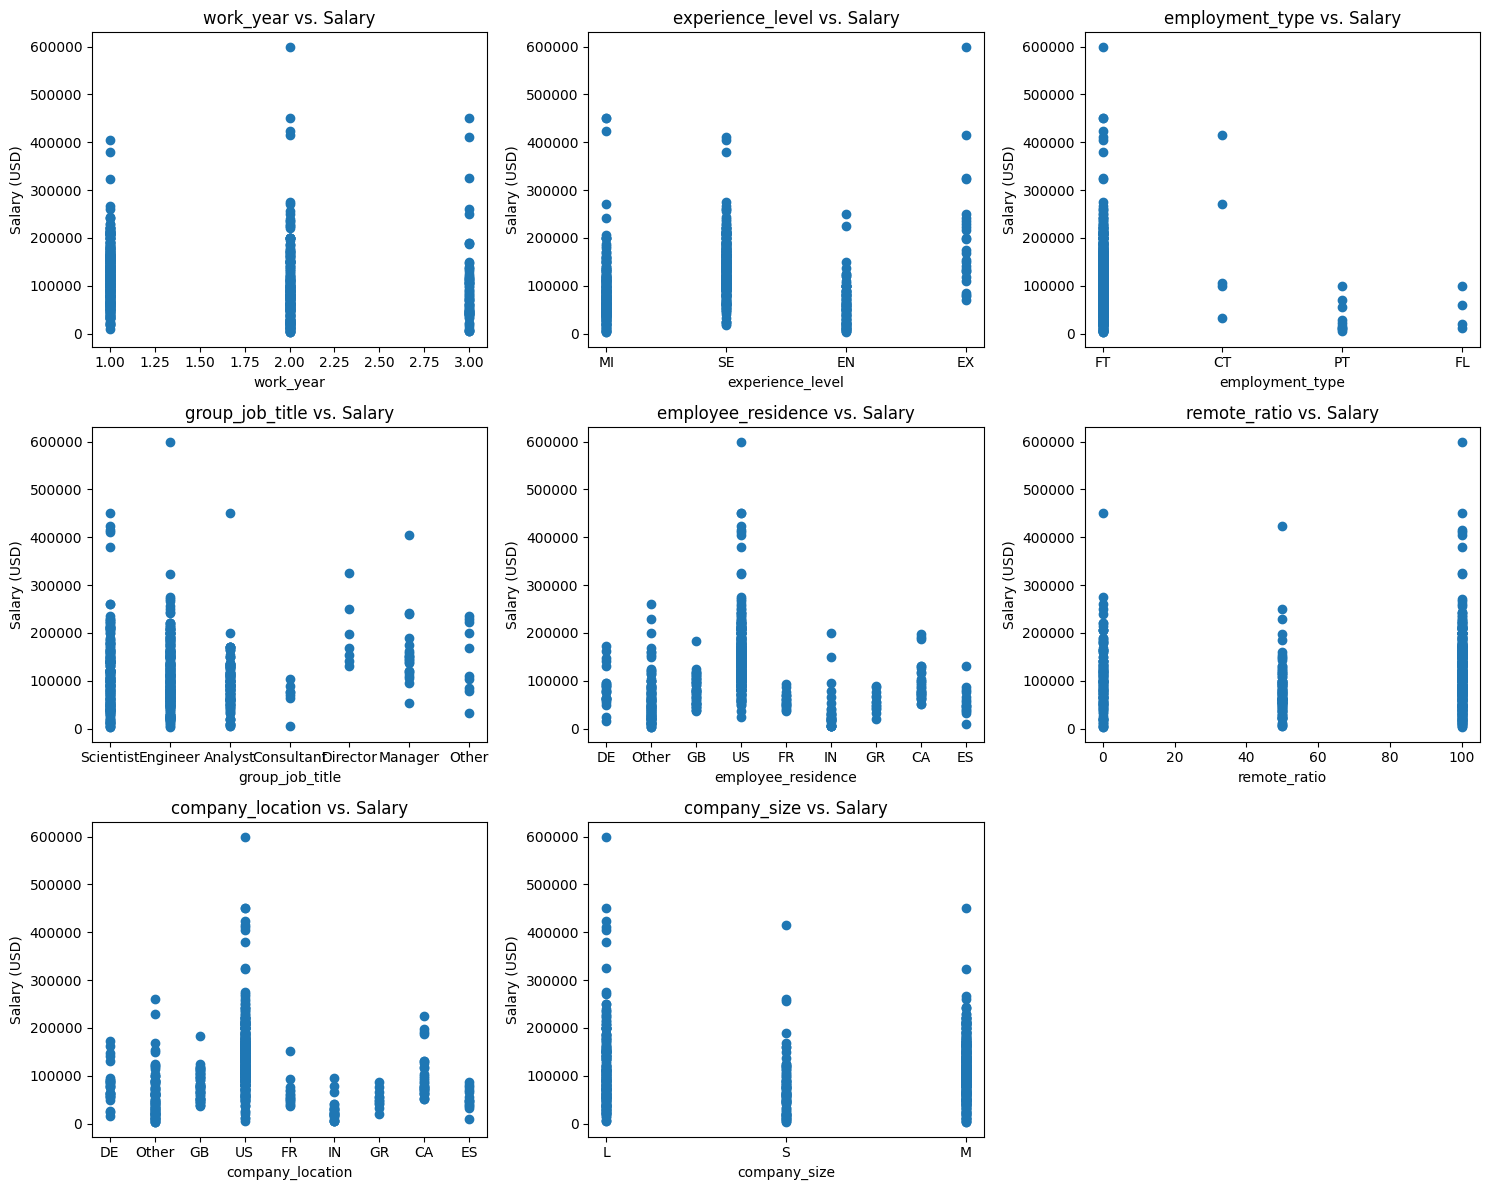

In [ ]:
import matplotlib.pyplot as plt

X_dataset = dataset.iloc[:, :-1]

# Define the number of plots to show in each row
plots_per_row = 3

# Calculate the number of rows needed
num_rows = len(X_dataset.columns) // plots_per_row
if len(X_dataset.columns) % plots_per_row != 0:
    num_rows += 1

# Create a grid of scatter plots with multiple plots in one row
fig, axes = plt.subplots(num_rows, plots_per_row, figsize=(15, 4 * num_rows))

for i, col in enumerate(X_dataset.columns):
    row_index = i // plots_per_row
    col_index = i % plots_per_row
    ax = axes[row_index, col_index]
    ax.scatter(X_dataset[col], dataset["salary_in_usd"])
    ax.set_title(f"{col} vs. Salary")
    ax.set_xlabel(col)
    ax.set_ylabel("Salary (USD)")

# Remove any remaining empty subplots
for i in range(len(X_dataset.columns), num_rows * plots_per_row):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()


# Histogram of Salary

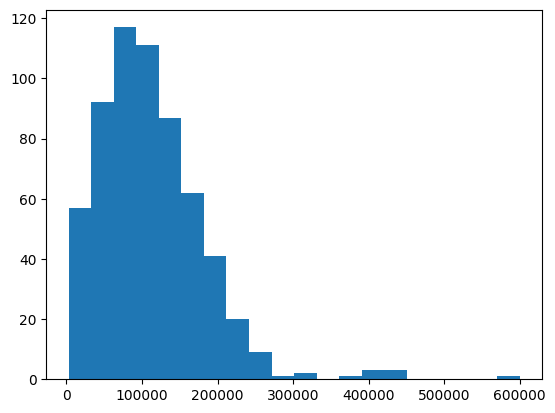

In [ ]:
plt.hist(dataset['salary_in_usd'], bins = 20)
plt.show()

# Defining X and y

In [ ]:
X = dataset.iloc[:, :-1].values
y = dataset.iloc[:, 8].values

In [ ]:
print(X.shape)
print(y.shape)

(607, 8)
(607,)


## Encoding categorical data and Splitting to Train and Test Set

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

columns_to_encode = [1, 2, 3, 4, 5, 6, 7]

# Create a ColumnTransformer to apply one-hot encoding to the specified columns
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), columns_to_encode)], remainder='passthrough')

# Fit and transform the ColumnTransformer on X
X_encoded = ct.fit_transform(X)

# Perform the train-test split
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=0)

In [ ]:
# Get the feature names for one-hot encoded columns
one_hot_encoder = ct.named_transformers_['encoder']
encoded_feature_names = one_hot_encoder.get_feature_names_out(input_features=dataset.columns[columns_to_encode])

# Columns that were not one-hot encoded
columns_not_encoded = [0]

# Create a list of feature names for non-encoded columns
feature_names_not_encoded = dataset.columns[columns_not_encoded].tolist()

# Combine feature names of one-hot encoded and non-encoded columns into a single list
all_feature_names = list(encoded_feature_names) + feature_names_not_encoded

# Print the combined list of feature names
print(all_feature_names)

# Print the first row of X_train with feature names
first_row = X_train[0].toarray().tolist()
print("First Row of X_train:")
print("all_feature_names")

['experience_level_EN', 'experience_level_EX', 'experience_level_MI', 'experience_level_SE', 'employment_type_CT', 'employment_type_FL', 'employment_type_FT', 'employment_type_PT', 'group_job_title_Analyst', 'group_job_title_Consultant', 'group_job_title_Director', 'group_job_title_Engineer', 'group_job_title_Manager', 'group_job_title_Other', 'group_job_title_Scientist', 'employee_residence_CA', 'employee_residence_DE', 'employee_residence_ES', 'employee_residence_FR', 'employee_residence_GB', 'employee_residence_GR', 'employee_residence_IN', 'employee_residence_Other', 'employee_residence_US', 'remote_ratio_0', 'remote_ratio_50', 'remote_ratio_100', 'company_location_CA', 'company_location_DE', 'company_location_ES', 'company_location_FR', 'company_location_GB', 'company_location_GR', 'company_location_IN', 'company_location_Other', 'company_location_US', 'company_size_L', 'company_size_M', 'company_size_S', 'work_year']
First Row of X_train:
experience_level_EN: [0.0, 0.0, 1.0, 0.0,

In [ ]:
print(X_train.shape)
print(X_test.shape)

(485, 40)
(122, 40)


In [ ]:
print(y_train.shape)
print(y_test.shape)

(485,)
(122,)


## Training the Multiple Linear Regression model on the Training set

In [ ]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression()

# Model Performance Measures

In [ ]:
import statsmodels.api as sm

# Calculate the R-squared value
r_squared = regressor.score(X_train, y_train)

# Get the number of observations and the number of predictors
num_observations = X_train.shape[0]
num_features = X_train.shape[1]

# Calculate the adjusted R-squared
adjusted_r_squared = 1 - (1 - r_squared) * (num_observations - 1) / (num_observations - num_features - 1)

print("R-squared:", r_squared)
print("Adjusted R-squared:", adjusted_r_squared)

R-squared: 0.5242306568911997
Adjusted R-squared: 0.4813685539084249


# Getting the final linear regression equation with the values of the coefficients

In [ ]:
# Get coefficients and intercept
coefficients = np.append(regressor.intercept_, regressor.coef_)

In [ ]:
# Calculate residuals
y_pred = regressor.predict(X_train)
residuals = y_train - y_pred

In [ ]:
# Calculate the standard errors of the coefficients
X_train_dense = X_train.toarray()  # Convert X_train to a dense array
X_train_with_intercept = np.column_stack((np.ones(X_train_dense.shape[0]), X_train_dense))  # Add a column of ones for the intercept
mse = np.mean(residuals ** 2)  # Mean squared error
covariance_matrix = np.linalg.pinv(np.dot(X_train_with_intercept.T, X_train_with_intercept)) * mse
se = np.sqrt(np.diag(covariance_matrix))

In [ ]:
from scipy import stats
from IPython.display import display, HTML

# Degrees of freedom
dof = X_train_with_intercept.shape[0] - len(coefficients)

# Calculate t-statistics, p-values, and confidence intervals
t_statistics = coefficients / se
p_values = [2 * (1 - stats.t.cdf(np.abs(t), dof)) for t in t_statistics]
alpha = 0.05
t_critical = stats.t.ppf(1 - alpha / 2, dof)
margin_of_error = t_critical * se
confidence_intervals = np.column_stack((coefficients - margin_of_error, coefficients + margin_of_error))

# Create a DataFrame to display the results
import pandas as pd

feature_names = ['Intercept'] + all_feature_names  # Include 'Intercept' as the first feature name
results_df = pd.DataFrame({'Feature': feature_names,
                           'Coefficient': coefficients,
                           'Standard Error': se,
                           't-Statistic': t_statistics,
                           't-critical': t_critical,
                           'p-Value': p_values,
                           'Lower CI': confidence_intervals[:, 0],
                           'Upper CI': confidence_intervals[:, 1]})

# Display the results using an HTML table
display(HTML(results_df.to_html(index=False)))


Feature,Coefficient,Standard Error,t-Statistic,t-critical,p-Value,Lower CI,Upper CI
Intercept,67639.072989,6317.197277,10.707133,1.965321,0.000000e+00,55223.750721,80054.395256
experience_level_EN,-41436.024166,6419.350833,-6.454862,1.965321,2.842255e-10,-54052.110990,-28819.937342
experience_level_EX,60881.459536,10242.916572,5.943762,1.965321,5.639693e-09,40750.837581,81012.081491
experience_level_MI,-22059.035338,5002.002790,-4.410041,1.965321,1.298169e-05,-31889.577887,-12228.492789
experience_level_SE,2613.599968,4792.933403,0.545303,1.965321,5.858191e-01,-6806.054065,12033.254001
employment_type_CT,-19143.246232,27448.533849,-0.697423,1.965321,4.859030e-01,-73088.434034,34801.941570
employment_type_FL,-13553.967455,21836.324595,-0.620707,1.965321,5.351107e-01,-56469.360957,29361.426046
employment_type_FT,15145.954507,10761.096321,1.407473,1.965321,1.599868e-01,-6003.057137,36294.966151
employment_type_PT,17551.259181,17301.544882,1.014433,1.965321,3.109286e-01,-16451.835231,51554.353592
group_job_title_Analyst,-28718.192735,7205.889048,-3.985378,1.965321,7.874327e-05,-42880.079855,-14556.305614


# Weights Plot

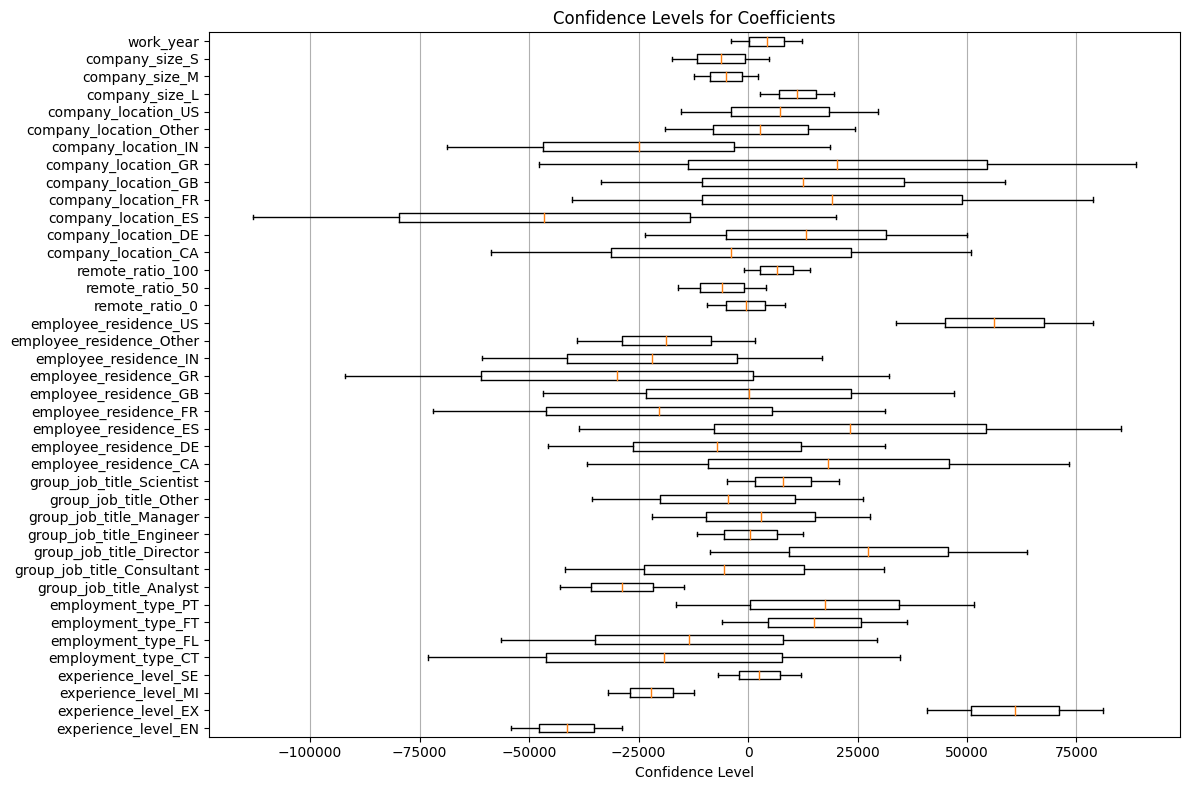

In [ ]:
# Initialize empty lists to store data and labels for box plots
boxplot_data = []
boxplot_labels = []

# Loop through coefficients, confidence intervals, and labels
for i in range(0, num_features): #all_feature_names does not include the intercept
    coefficient_label = all_feature_names[i]
    confidence_interval = confidence_intervals[i+1] # exclude the intercepts

    # Append the confidence interval data and label
    boxplot_data.append(confidence_interval)
    boxplot_labels.append(coefficient_label)

# Create a figure for all box plots
plt.figure(figsize=(12, 8))

# Create the box plots
plt.boxplot(boxplot_data, labels=boxplot_labels, vert=False)
plt.xlabel('Confidence Level')
plt.title('Confidence Levels for Coefficients')
plt.grid(axis='x')
plt.tight_layout()

# Show the box plots
plt.show()

# Effects plot

In [ ]:
# Determining the effects of each feature
boxplot_data = []
boxplot_labels = []
#num_observations = X_train.shape[0]
#num_features = X_train.shape[1]

effects = np.empty((num_observations,num_features))

# Loop through coefficients, confidence intervals, and labels
for i in range(0, num_features):
    for j in range (0, X_train.shape[0]):
      effects[j,i] = coefficients[i+1]  * X_train[j,i]

print(effects.shape)

(485, 40)


(485, 8)


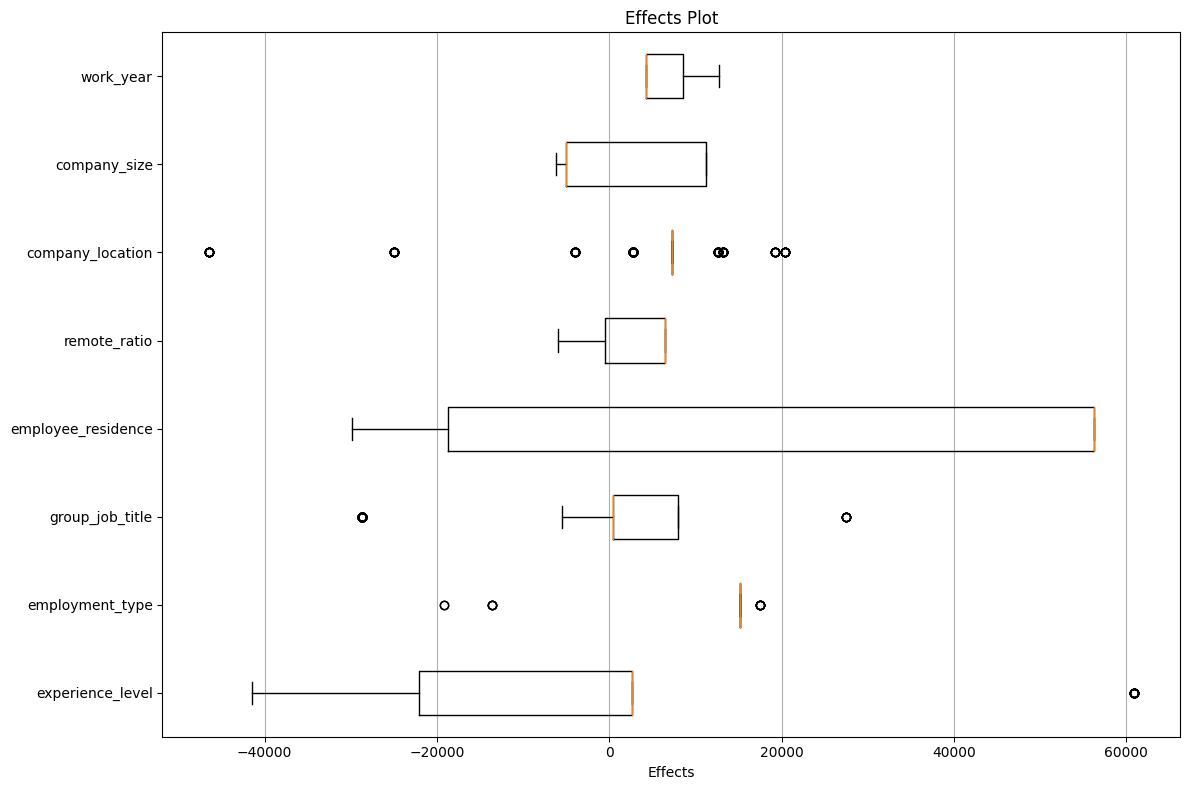

In [ ]:
# Summarizing the effects of categorical variables

orig_num_categories = X.shape[1]
effects_matrix = np.zeros((num_observations, orig_num_categories))

# Define the category mapping including both one-hot encoded and non-one-hot encoded categories
category_mapping = {
    'experience_level': ['experience_level_EN', 'experience_level_EX', 'experience_level_MI', 'experience_level_SE'],
    'employment_type': ['employment_type_CT', 'employment_type_FL', 'employment_type_FT', 'employment_type_PT'],
    'group_job_title': ['group_job_title_Analyst', 'group_job_title_Consultant', 'group_job_title_Director', 'group_job_title_Engineer', 'group_job_title_Manager', 'group_job_title_Other', 'group_job_title_Scientist'],
    'employee_residence': ['employee_residence_CA', 'employee_residence_DE', 'employee_residence_ES', 'employee_residence_FR', 'employee_residence_GB', 'employee_residence_GR', 'employee_residence_IN', 'employee_residence_Other', 'employee_residence_US'],
    'remote_ratio': ['remote_ratio_0', 'remote_ratio_50', 'remote_ratio_100'],
    'company_location': ['company_location_CA', 'company_location_DE', 'company_location_ES', 'company_location_FR', 'company_location_GB', 'company_location_GR', 'company_location_IN', 'company_location_Other', 'company_location_US'],
    'company_size': ['company_size_L', 'company_size_M', 'company_size_S'],
    'work_year': ['work_year'],
}

# Iterate through the categories and calculate and populate the effects matrix
for i, (category, columns) in enumerate(category_mapping.items()):
    # Get the column indices corresponding to the category
    column_indices = [all_feature_names.index(col) for col in columns]

    # Calculate the sum of effects for each observation and populate the effects matrix
    effects_matrix[:, i] = np.sum(effects[:, column_indices], axis=1)

print(effects_matrix.shape)

# Create a list of labels using the keys from the category_mapping dictionary
boxplot_labels = list(category_mapping.keys())

# Create a figure for all box plots
plt.figure(figsize=(12, 8))

# Create the box plots with labels as category names
plt.boxplot(effects_matrix, labels=boxplot_labels, vert=False)
plt.xlabel('Effects')
plt.title('Effects Plot')
plt.grid(axis='x')
plt.tight_layout()

# Show the box plots
plt.show()


# Fitting a Regression with Single Feature

In [ ]:
# Define the category mapping including both one-hot encoded and non-one-hot encoded categories
category_mapping = {
    'experience_level': ['experience_level_EN', 'experience_level_EX', 'experience_level_MI', 'experience_level_SE'],
    'employment_type': ['employment_type_CT', 'employment_type_FL', 'employment_type_FT', 'employment_type_PT'],
    'group_job_title': ['group_job_title_Analyst', 'group_job_title_Consultant', 'group_job_title_Director', 'group_job_title_Engineer', 'group_job_title_Manager', 'group_job_title_Other', 'group_job_title_Scientist'],
    'employee_residence': ['employee_residence_CA', 'employee_residence_DE', 'employee_residence_ES', 'employee_residence_FR', 'employee_residence_GB', 'employee_residence_GR', 'employee_residence_IN', 'employee_residence_Other', 'employee_residence_US'],
    'remote_ratio': ['remote_ratio_0', 'remote_ratio_50', 'remote_ratio_100'],
    'company_location': ['company_location_CA', 'company_location_DE', 'company_location_ES', 'company_location_FR', 'company_location_GB', 'company_location_GR', 'company_location_IN', 'company_location_Other', 'company_location_US'],
    'company_size': ['company_size_L', 'company_size_M', 'company_size_S'],
    'work_year': ['work_year'],
}

feature_regressor = LinearRegression()
# Iterate through the categories and calculate and populate the effects matrix
for i, (category, columns) in enumerate(category_mapping.items()):
    # Get the column indices corresponding to the category
    column_indices = [all_feature_names.index(col) for col in columns]
    # Get the corresponding columns in X_train
    X_train_feature = X_train[:, column_indices]
    # Fit the regressor
    feature_regressor.fit(X_train_feature, y_train)
    # Calculate the R-squared value
    r_squared = feature_regressor.score(X_train_feature, y_train)
    print(f"R-squared for {category}: {r_squared}")

R-squared for experience_level: 0.23548828765292618
R-squared for employment_type: 0.026652031356892425
R-squared for group_job_title: 0.046862472985566894
R-squared for employee_residence: 0.35578289289415943
R-squared for remote_ratio: 0.04763449913843587
R-squared for company_location: 0.3012160287775222
R-squared for company_size: 0.045269836750681636
R-squared for work_year: 0.026940056173950455


# Fitting Regression with Selected Features

In [ ]:
# Define the categories you want to include
selected_categories = [
    'experience_level_EN', 'experience_level_EX', 'experience_level_MI', 'experience_level_SE',
    # 'employment_type_CT', 'employment_type_FL', 'employment_type_FT', 'employment_type_PT',
    # 'group_job_title_Analyst', 'group_job_title_Consultant', 'group_job_title_Director',
    # 'group_job_title_Engineer', 'group_job_title_Manager', 'group_job_title_Other', 'group_job_title_Scientist',
    'employee_residence_CA', 'employee_residence_DE', 'employee_residence_ES',
    'employee_residence_FR', 'employee_residence_GB', 'employee_residence_GR',
    'employee_residence_IN', 'employee_residence_Other', 'employee_residence_US',
    # 'remote_ratio_0', 'remote_ratio_50', 'remote_ratio_100',
    'company_location_CA', 'company_location_DE', 'company_location_ES',
    'company_location_FR', 'company_location_GB', 'company_location_GR',
    'company_location_IN', 'company_location_Other', 'company_location_US',
    'company_size_L', 'company_size_M', 'company_size_S',
    # 'work_year'
]

# Find the indices of the selected columns in the original X_train
selected_indices = [all_feature_names.index(col) for col in selected_categories]

# Create a new X_train based on the selected columns
X_train_selected = X_train[:, selected_indices]

# Fit the model
selected_regressor = LinearRegression()
selected_regressor.fit(X_train_selected, y_train)

# Calculate the R-squared value
r_squared = selected_regressor.score(X_train_selected, y_train)
print(f"R-squared: {r_squared}")

R-squared: 0.4822484617345305


# Lasso Regression

In [ ]:
from sklearn.linear_model import Lasso

lasso = Lasso(alpha = 100)
lasso.fit(X_train, y_train)

Lasso(alpha=100)

In [ ]:
# Calculate the R-squared value
lasso_r_squared = lasso.score(X_train, y_train)

print(f"Laso R-squared: {lasso_r_squared}")


Laso R-squared: 0.5211290196009797


In [ ]:
# Get coefficients and intercept
lasso_coefficients = np.append(lasso.intercept_, lasso.coef_)

In [ ]:
# Calculate residuals
lasso_y_pred = lasso.predict(X_train)
lasso_residuals = y_train - lasso_y_pred

In [ ]:
# Calculate the standard errors of the coefficients
X_train_dense = X_train.toarray()  # Convert X_train to a dense array
X_train_with_intercept = np.column_stack((np.ones(X_train_dense.shape[0]), X_train_dense))  # Add a column of ones for the intercept
mse = np.mean(lasso_residuals ** 2)  # Mean squared error
covariance_matrix = np.linalg.pinv(np.dot(X_train_with_intercept.T, X_train_with_intercept)) * mse
se = np.sqrt(np.diag(covariance_matrix))

In [ ]:
from scipy import stats
from IPython.display import display, HTML

# Degrees of freedom
dof = X_train_with_intercept.shape[0] - len(lasso_coefficients)

# Calculate t-statistics, p-values, and confidence intervals
t_statistics = lasso_coefficients / se
p_values = [2 * (1 - stats.t.cdf(np.abs(t), dof)) for t in t_statistics]
alpha = 0.05
t_critical = stats.t.ppf(1 - alpha / 2, dof)
margin_of_error = t_critical * se
confidence_intervals = np.column_stack((lasso_coefficients - margin_of_error, lasso_coefficients + margin_of_error))

# Create a DataFrame to display the results
import pandas as pd

feature_names = ['Intercept'] + all_feature_names  # Include 'Intercept' as the first feature name
results_df = pd.DataFrame({'Feature': feature_names,
                           'Lasso_Coefficient': lasso_coefficients,
                           'Standard Error': se,
                           't-Statistic': t_statistics,
                           't-critical': t_critical,
                           'p-Value': p_values,
                           'Lower CI': confidence_intervals[:, 0],
                           'Upper CI': confidence_intervals[:, 1]})

# Display the results using an HTML table
display(HTML(results_df.to_html(index=False)))

Feature,Lasso_Coefficient,Standard Error,t-Statistic,t-critical,p-Value,Lower CI,Upper CI
Intercept,71746.255141,6337.755374,11.320452,1.965321,0.000000e+00,59290.529608,84201.980674
experience_level_EN,-38681.424505,6440.241369,-6.006207,1.965321,3.956386e-09,-51338.567944,-26024.281066
experience_level_EX,59676.880111,10276.250163,5.807262,1.965321,1.211383e-08,39480.746939,79873.013282
experience_level_MI,-19941.357921,5018.280841,-3.973743,1.965321,8.255275e-05,-29803.892070,-10078.823772
experience_level_SE,3797.421187,4808.531078,0.789726,1.965321,4.301094e-01,-5652.887288,13247.729663
employment_type_CT,-941.172278,27537.859794,-0.034177,1.965321,9.727511e-01,-55061.914262,53179.569705
employment_type_FL,-6406.130746,21907.386690,-0.292419,1.965321,7.701031e-01,-49461.184097,36648.922605
employment_type_FT,7384.079545,10796.116228,0.683957,1.965321,4.943591e-01,-13833.757467,28601.916558
employment_type_PT,53.375374,17357.849414,0.003075,1.965321,9.975479e-01,-34060.375533,34167.126281
group_job_title_Analyst,-29356.444912,7229.339221,-4.060737,1.965321,5.782472e-05,-43564.419155,-15148.470668


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from numpy import arange

# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=10, random_state=1)

# define grid
grid = dict()
grid['alpha'] = arange(0, 100, 1)

# define search
search = GridSearchCV(lasso, grid, scoring='r2', cv=cv, n_jobs=-1)
# perform the search
results = search.fit(X_train, y_train)

# Get the best alpha and R-squared value
best_alpha = results.best_params_['alpha']
best_r2 = results.best_score_

# summarize
print('Best Alpha: %.3f' % best_alpha)
print('Best R-squared: %.3f' % best_r2)

Best Alpha: 99.000
Best R-squared: 0.471


# Ridge Regression

In [ ]:
from sklearn.linear_model import Ridge

ridge = Ridge(alpha=10)
ridge.fit(X_train,y_train)

Ridge(alpha=10)

In [ ]:
# Get coefficients and intercept
ridge_coefficients = np.append(ridge.intercept_, ridge.coef_)

In [ ]:
# Calculate the R-squared value
ridge_r_squared = ridge.score(X_train, y_train)

print(f"Ridge R-squared: {ridge_r_squared}")

Ridge R-squared: 0.5130194584257542


In [ ]:
# Calculate residuals
ridge_y_pred = ridge.predict(X_train)
ridge_residuals = y_train - ridge_y_pred

In [ ]:
# Calculate the standard errors of the coefficients
X_train_dense = X_train.toarray()  # Convert X_train to a dense array
X_train_with_intercept = np.column_stack((np.ones(X_train_dense.shape[0]), X_train_dense))  # Add a column of ones for the intercept
mse = np.mean(ridge_residuals ** 2)  # Mean squared error
covariance_matrix = np.linalg.pinv(np.dot(X_train_with_intercept.T, X_train_with_intercept)) * mse
se = np.sqrt(np.diag(covariance_matrix))

In [ ]:
from scipy import stats
from IPython.display import display, HTML

# Degrees of freedom
dof = X_train_with_intercept.shape[0] - len(ridge_coefficients)

# Calculate t-statistics, p-values, and confidence intervals
t_statistics = ridge_coefficients / se
p_values = [2 * (1 - stats.t.cdf(np.abs(t), dof)) for t in t_statistics]
alpha = 0.05
t_critical = stats.t.ppf(1 - alpha / 2, dof)
margin_of_error = t_critical * se
confidence_intervals = np.column_stack((ridge_coefficients - margin_of_error, ridge_coefficients + margin_of_error))

# Create a DataFrame to display the results
import pandas as pd

feature_names = ['Intercept'] + all_feature_names  # Include 'Intercept' as the first feature name
results_df = pd.DataFrame({'Feature': feature_names,
                           'Lasso_Coefficient': ridge_coefficients,
                           'Standard Error': se,
                           't-Statistic': t_statistics,
                           't-critical': t_critical,
                           'p-Value': p_values,
                           'Lower CI': confidence_intervals[:, 0],
                           'Upper CI': confidence_intervals[:, 1]})

# Display the results using an HTML table
display(HTML(results_df.to_html(index=False)))

Feature,Lasso_Coefficient,Standard Error,t-Statistic,t-critical,p-Value,Lower CI,Upper CI
Intercept,74083.659614,6322.658650,11.717169,1.965321,0.000000,61657.603994,86509.715233
experience_level_EN,-31871.732830,6424.900520,-4.960658,1.965321,0.000001,-44498.726573,-19244.739088
experience_level_EX,44069.793278,10251.771826,4.298749,1.965321,0.000021,23921.767905,64217.818652
experience_level_MI,-17912.357364,5006.327145,-3.577944,1.965321,0.000384,-27751.398659,-8073.316069
experience_level_SE,5714.296916,4797.077012,1.191204,1.965321,0.234210,-3713.500640,15142.094472
employment_type_CT,-3926.969941,27472.263783,-0.142943,1.965321,0.886400,-57918.794687,50064.854805
employment_type_FL,-6824.295360,21855.202635,-0.312250,1.965321,0.754997,-49776.790277,36128.199557
employment_type_FT,10072.610663,10770.399554,0.935212,1.965321,0.350187,-11094.684823,31239.906149
employment_type_PT,678.654638,17316.502494,0.039191,1.965321,0.968756,-33353.836287,34711.145562
group_job_title_Analyst,-26401.144048,7212.118717,-3.660664,1.965321,0.000282,-40575.274469,-12227.013627


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from numpy import arange

# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=10, random_state=1)

# define grid
grid = dict()
grid['alpha'] = arange(0, 100, 1)

# define search
search = GridSearchCV(ridge, grid, scoring='r2', cv=cv, n_jobs=-1)

# perform the search
results = search.fit(X_train, y_train)

# Get the best alpha and R-squared value
best_alpha = results.best_params_['alpha']
best_r2 = results.best_score_

# summarize
print('Best Alpha: %.3f' % best_alpha)
print('Best R-squared: %.3f' % best_r2)

Best Alpha: 9.000
Best R-squared: 0.484
